
... ***CURRENTLY UNDER DEVELOPMENT*** ...


In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt
import shutil

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.climate_emulator import Climate_Emulator

from teslakit.plotting.waves import Plot_Waves_Histogram_FitSim



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database
p_data = r'/Users/albacid/Projects/TeslaKit_projects'
site ='ROI'

# set site
db = Database(p_data)
db.SetSite(site)


p_data = r'/Users/albacid/Projects/TeslaKit_projects/sites/' + site + '/'
p_outputs = p_data + 'ClimateChange_SLR_ENSO/'

# TODO: copy alr_w folder 
shutil.copytree(p_data + 'EXTREMES/climate_emulator/', p_outputs + 'EXTREMES/climate_emulator/') 

# TODO: remove content of EXTREMES/climate_emulator/Simulations (did it manually)


In [3]:
# --------------------------------------
# Load data for plotting (waves partitions and families, KMA, DWT)

WVS = db.Load_WAVES_hist()      # Historical gow waves point
KMA = db.Load_ESTELA_KMA()      # ESTELA predictor KMA

# prepare KMA data 
DWTs_fit = xr.Dataset(
    {
        'bmus'       : ('time', KMA['sorted_bmus_storms'].values[:] + 1),
        'cenEOFs'    : (('n_clusters', 'n_features',), KMA['cenEOFs'].values[:]),
    },
    coords = {'time' : KMA['time'].values[:]}
)

# Waves and KMA bmus data share time dimension
WVS_fit = WVS.sel(time = DWTs_fit.time)


# --------------------------------------
# Load data for climate emulator simulation: ESTELA DWT and TCs (MU, TAU) 

DWTs_sim = xr.open_dataset(p_outputs + 'ESTELA/CC_DWT_sim.nc')

TCs_params = db.Load_TCs_r2_sim_params()    # TCs parameters (copula generated) 
TCs_RBFs = db.Load_TCs_sim_r2_rbf_output()  # TCs numerical_IH-RBFs_interpolation output

probs_TCs =  db.Load_TCs_probs_synth()      # TCs synthetic probabilities
pchange_TCs = probs_TCs['category_change_cumsum'].values[:]

l_mutau_wt = db.Load_MU_TAU_hydrograms()   # MU - TAU intradaily hidrographs for each DWT
MU_WT = np.array([x.MU.values[:] for x in l_mutau_wt])  # MU and TAU numpy arrays
TAU_WT = np.array([x.TAU.values[:] for x in l_mutau_wt])





In [4]:
# TODO developer
DWTs_sim = DWTs_sim.isel(n_sim=slice(0, 10))



## Climate Emulator - Fitting

In [5]:
# --------------------------------------

# climate emulator object
CE = Climate_Emulator(p_outputs + 'EXTREMES/climate_emulator/')


# Load Climate Emulator
CE.Load()


## Climate Emulator - Simulation

In [6]:
# --------------------------------------
#  Climate Emulator simulation

## each DWT series will generate a different set of waves
#for n in DWTs_sim.n_sim:
#    print('- Sim: {0} -'.format(int(n)+1))
    
#    # Select DWTs simulation
#    DWTs = DWTs_sim.sel(n_sim=n)

#    # Simulate waves
#    n_ce = 1  # (one CE sim. for each DWT sim.)
#    WVS_sim = CE.Simulate_Waves(DWTs, n_ce, filters={'hs':True, 'tp':True, 'ws':True})

#    # Simulate TCs and update simulated waves
#    TCs_sim, WVS_upd = CE.Simulate_TCs(DWTs, WVS_sim, TCs_params, TCs_RBFs, pchange_TCs, MU_WT, TAU_WT)
    
#    # store simulation data
#    CE.SaveSim(WVS_sim, TCs_sim, WVS_upd, int(n))

    
WVS_sim, TCs_sim, WVS_upd = CE.LoadSim()

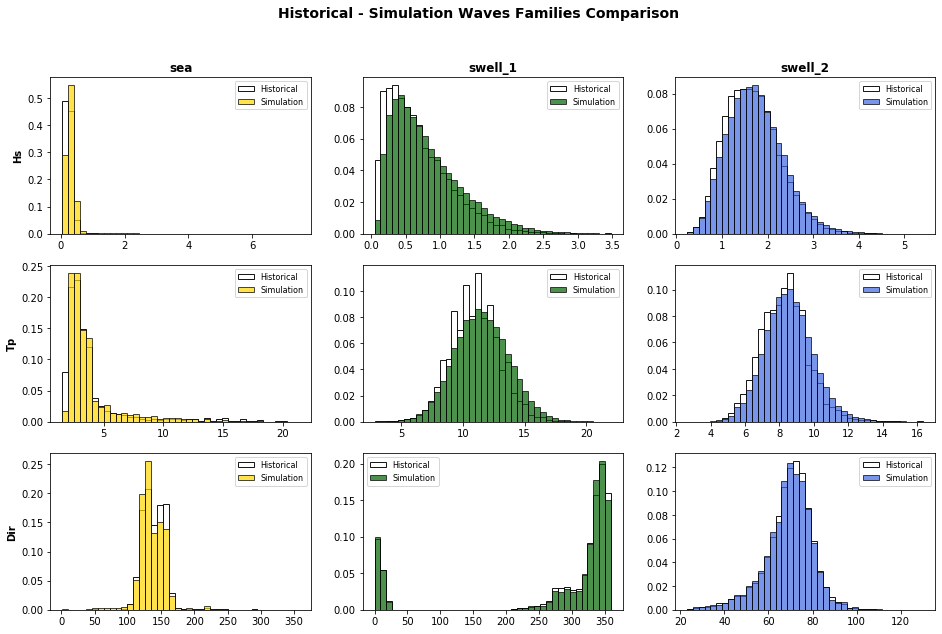

In [7]:
# --------------------------------------
# Select Simulation to plot

# 2 levels of simulation now:
n_sim_DWTs = 0  # switch DWTs Simulation (used at CE Sim.)
n_sim_CE = 0    # switch WAVES Simulation (generated from CE Sim.)

# Load Waves simulated for DWTs set number "n_sim_DWTs"
WVS_sim, TCs_sim, WVS_upd = CE.LoadSim(n_sim = n_sim_DWTs)

# Plot simulated waves parameters distribution 
Plot_Waves_Histogram_FitSim(WVS_fit, WVS_upd.isel(n_sim = n_sim_CE));
